# Predicting stock price moves with Logistic Regression


## Imports & Settings


In [1]:
import warnings



warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style("darkgrid")
idx = pd.IndexSlice

In [5]:
YEAR = 252

## Load Data


In [6]:
with pd.HDFStore("data.h5") as store:
    data = store["model_data"].dropna().drop(["open", "close", "low", "high"], axis=1)
data = data.drop([c for c in data.columns if "year" in c or "lag" in c], axis=1)

### Select Investment Universe


In [7]:
data = data[data.dollar_vol_rank < 100]

### Create Model Data


In [8]:
y = data.filter(like="target")
X = data.drop(y.columns, axis=1)
X = X.drop(["dollar_vol", "dollar_vol_rank", "volume", "consumer_durables"], axis=1)

## Logistic Regression


### Define cross-validation parameters


In [9]:
train_period_length = 63
test_period_length = 10
lookahead = 1
n_splits = int(3 * YEAR / test_period_length)

cv = MultipleTimeSeriesCV(
    n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length,
)

In [10]:
target = f"target_{lookahead}d"

In [11]:
y.loc[:, "label"] = (y[target] > 0).astype(int)
y["label"].value_counts()

label
1    56486
0    53189
Name: count, dtype: int64

In [12]:
Cs = np.logspace(-5, 5, 11)

In [13]:
cols = ["C", "date", "auc", "ic", "pval"]

### Run cross-validation


In [14]:
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C, fit_intercept=True, random_state=42, n_jobs=-1)

    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        (
            X_train,
            y_train,
        ) = (
            X.iloc[train_idx],
            y.label.iloc[train_idx],
        )
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(
            y_test.to_frame("labels").assign(predicted=y_score, C=C, actuals=actuals)
        )
        date = y_test.index.get_level_values("date").min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps["model"].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f"\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}")

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05
	  4.6 | 010 |  -0.31% |  50.42%
	  8.7 | 020 |   1.89% |  51.83%
	 13.0 | 030 |   2.84% |  52.01%
	 14.9 | 040 |   3.29% |  51.98%
	 16.2 | 050 |   3.97% |  52.44%
	 17.5 | 060 |   3.96% |  52.27%
	 18.8 | 070 |   4.73% |  52.59%
0.0001
	  1.2 | 010 |  -0.06% |  50.62%
	  2.5 | 020 |   2.22% |  52.01%
	  3.8 | 030 |   3.20% |  52.26%
	  5.1 | 040 |   3.34% |  52.08%
	  6.3 | 050 |   4.02% |  52.52%
	  7.6 | 060 |   4.02% |  52.32%
	  8.9 | 070 |   4.82% |  52.67%
0.001
	  1.3 | 010 |   0.42% |  50.96%
	  2.6 | 020 |   2.53% |  52.14%
	  3.9 | 030 |   3.58% |  52.48%
	  5.2 | 040 |   3.17% |  52.07%
	  6.3 | 050 |   3.84% |  52.49%
	  7.6 | 060 |   4.03% |  52.33%
	  9.0 | 070 |   4.88% |  52.70%
0.01
	  1.3 | 010 |   0.69% |  51.14%
	  2.6 | 020 |   2.39% |  51.97%
	  3.9 | 030 |   3.64% |  52.41%
	  5.2 | 040 |   3.12% |  51.94%
	  6.4 | 050 |   3.91% |  52.45%
	  7.7 | 060 |   4.15% |  52.30%
	  9.0 | 070 |   4.90% |  52.64%
0.1
	  1.3 | 010 |   0.65% |  51.11%
	  2.6 | 020 | 

### Evaluate Results


In [15]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf("data.h5", "logistic/scores")

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf("data.h5", "logistic/coeffs")

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf("data.h5", "logistic/predictions")

In [16]:
log_scores = pd.read_hdf("data.h5", "logistic/scores")

In [17]:
log_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 38.7 KB


In [18]:
log_scores.groupby("C")["auc"].describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524319,0.036129,0.432474,0.499748,0.519363,0.546010,0.625910
0.00010,75.0,0.525027,0.035672,0.442546,0.501468,0.520045,0.546001,0.635522
0.00100,75.0,0.525451,0.036366,0.438760,0.500371,0.520116,0.545270,0.641135
0.01000,75.0,0.525041,0.036924,0.435667,0.500665,0.522229,0.550606,0.641525
0.10000,75.0,0.523519,0.036514,0.427242,0.499618,0.522998,0.549215,0.622396
1.00000,75.0,0.523177,0.036477,0.425275,0.498439,0.521708,0.549034,0.616945
10.00000,75.0,0.523111,0.036482,0.424928,0.498357,0.521492,0.549019,0.616243
100.00000,75.0,0.523101,0.036484,0.424913,0.498355,0.521455,0.549040,0.616148
1000.00000,75.0,0.523100,0.036486,0.424894,0.498361,0.521451,0.549036,0.616153


### Plot Validation Scores


In [19]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls="--", c="k")
    ax.text(
        x=0.05,
        y=0.9,
        s=f"Mean: {mean:8.2f}\nMedian: {median:5.2f}",
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
    )
    ax.set_xlabel("Information Coefficient")
    sns.despine()
    plt.tight_layout()

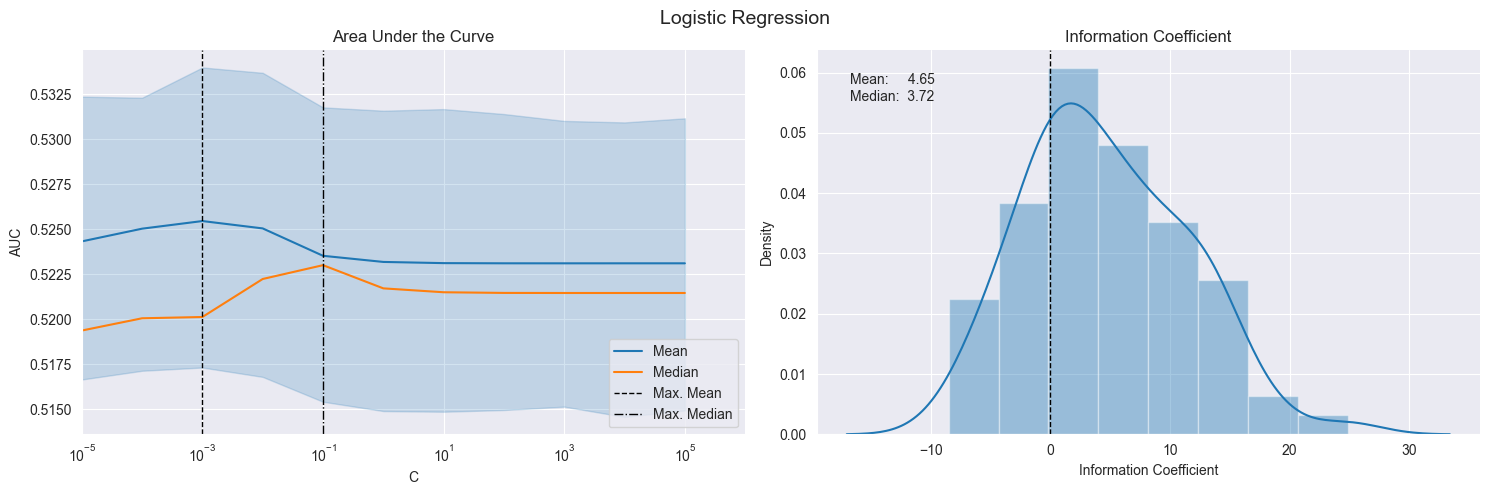

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(
    x="C", y="auc", data=log_scores, estimator=np.mean, label="Mean", ax=axes[0]
)
by_alpha = log_scores.groupby("C").auc.agg(["mean", "median"])
best_auc = by_alpha["mean"].idxmax()
by_alpha["median"].plot(logx=True, ax=axes[0], label="Median", xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls="--", c="k", lw=1, label="Max. Mean")
axes[0].axvline(by_alpha["median"].idxmax(), ls="-.", c="k", lw=1, label="Max. Median")
axes[0].legend()
axes[0].set_ylabel("AUC")
axes[0].set_xscale("log")
axes[0].set_title("Area Under the Curve")

plot_ic_distribution(log_scores[log_scores.C == best_auc], ax=axes[1])
axes[1].set_title("Information Coefficient")

fig.suptitle("Logistic Regression", fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()